In [1]:
import pandas as pd
import numpy as np
import acessos as ac
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sqlalchemy import create_engine
import os
import boto3


In [3]:
!pip install awswrangler

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [4]:
import awswrangler as wr

In [3]:
query = '''

select * from customer_sandbox_zone.segmentacao_digital_credito_flavia

'''

In [7]:
#df = ac.df_athena('flavia-costa', query)

In [6]:
staging_path = 's3://will-prod-ml-platform-sagemaker-studio/staging/flavia-costa/'
boto3_session = boto3.Session(region_name='sa-east-1')

# Clean temporary folder
wr.s3.delete_objects(staging_path, boto3_session=boto3_session)

# Run query
print('Started query')

df = wr.athena.read_sql_query(
    sql=query,
    database=None,
    unload_approach=True,
    ctas_approach=False,
    boto3_session=boto3_session,
    s3_output=staging_path
)
wr.s3.delete_objects(staging_path, boto3_session=boto3_session)

Started query


In [9]:
df.head()

,cpf,tempo_relacionamento,ds_risk_type,gender,nr_declared_income,ds_region,ds_occupation,nm_current_os,ds_city_size,flag_autonomo,...,trans_recorrente,trans_mobilidade_app,trans_delivery,trans_recarga_geral,trans_streaming,trans_rede_social,trans_games,trans_cripto,ds_cluster_sociodemographic,ordem
0,62492807312,1043,4. Baixo Risco,FEMALE,0.01,Nordeste,VENDEDOR DE LOJAS,ios,pequeno,0,...,14,0,0,0,14,0,0,0,"10 - Mulher, Solteira, Até 24 anos, cidade Peq...",1087
1,09095124509,398,3. Medio Risco,FEMALE,5000.00,Nordeste,Agrônomo(a),ios,pequeno,0,...,0,0,0,0,0,0,0,0,"10 - Mulher, Solteira, Até 24 anos, cidade Peq...",1088
2,70546989403,1490,4. Baixo Risco,FEMALE,0.01,Nordeste,DOMÉSTICO,<NA>,pequeno,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"10 - Mulher, Solteira, Até 24 anos, cidade Peq...",1089
3,05411712327,1336,3. Medio Risco,FEMALE,0.01,Nordeste,ATENDENTE,android,pequeno,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"10 - Mulher, Solteira, Até 24 anos, cidade Peq...",1090
4,02594262536,1990,1. Sem Informacao,FEMALE,0.01,Nordeste,BALCONISTA,ios,pequeno,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"10 - Mulher, Solteira, Até 24 anos, cidade Peq...",1091


In [10]:
df.dtypes

cpf                             string
tempo_relacionamento             Int64
ds_risk_type                    string
gender                          string
nr_declared_income             float64
ds_region                       string
ds_occupation                   string
nm_current_os                   string
ds_city_size                    string
flag_autonomo                    Int32
nr_trans_pix                     Int64
nr_antecipacao_fatura            Int64
flag_bolso                       Int32
nr_purchases_virtual             Int64
avg_vl_total_spending          float64
nr_purchases_online              Int64
nr_purchases_contactless         Int64
nr_recarga_credito               Int64
nr_acessos                       Int64
pc_acessos_lojawill            float64
nr_pagamentos_conta              Int64
nr_pagamentos_conta_credito      Int64
trans_recorrente                 Int64
trans_mobilidade_app             Int64
trans_delivery                   Int64
trans_recarga_geral      

In [7]:
for column in df.columns:
  if df[column].dtype == 'object' or df[column].dtype == 'string':
    df[column].fillna(df[column].mode()[0], inplace = True)
  elif df[column].dtype != 'object' and df[column].dtype != 'string':
    df[column].fillna(df[column].median(), inplace = True)

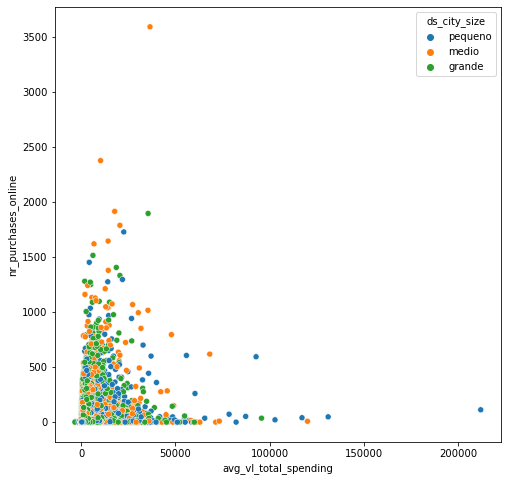

In [12]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=df, x="avg_vl_total_spending", y="nr_purchases_online", hue="ds_city_size")
plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from statsmodels.stats.proportion import proportions_ztest
from sklearn.decomposition import PCA


features_cluster = ['nr_trans_pix',
       'nr_antecipacao_fatura', 'flag_bolso', 'nr_purchases_virtual',
       'avg_vl_total_spending', 'nr_purchases_online',
       'nr_purchases_contactless', 'nr_recarga_credito', 'nr_acessos',
       'pc_acessos_lojawill', 'nr_pagamentos_conta',
       'nr_pagamentos_conta_credito', 'trans_recorrente',
       'trans_mobilidade_app', 'trans_delivery', 'trans_recarga_geral',
       'trans_streaming', 'trans_rede_social', 'trans_games', 'trans_cripto']

base_cluster = df[features_cluster]


In [9]:
#NORMALIZAÇÃO
scaler = RobustScaler()
scaler_model = scaler.fit(base_cluster)
data_input_scaled = scaler_model.transform(base_cluster)

In [15]:
pca = PCA(n_components=0.95) #Explicar 95% da variância
pca.fit(base_cluster)
base_cluster_pca = pca.transform(data_input_scaled)

print(base_cluster_pca.shape[1])

1


In [16]:
pca = PCA(n_components=2)
pca.fit(base_cluster)
base_cluster_pca = pca.transform(data_input_scaled)


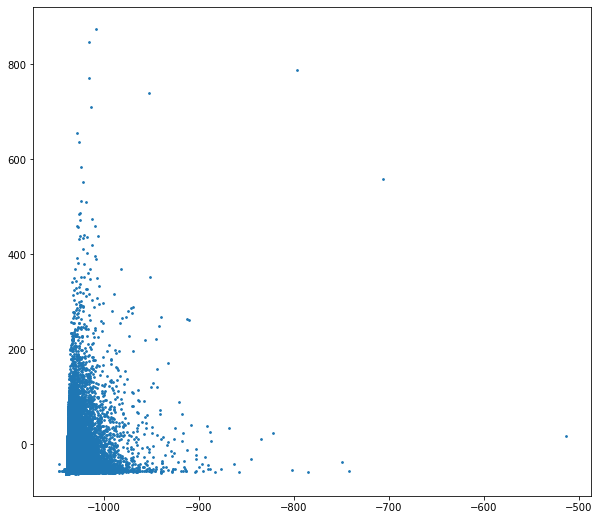

In [17]:
plt.figure(figsize=(10,9))
plt.scatter(base_cluster_pca[:, 0], base_cluster_pca[:, 1], s=3, cmap='Spectral')
plt.show()

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8f0318d5e0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8f03186ca0>
Traceback 

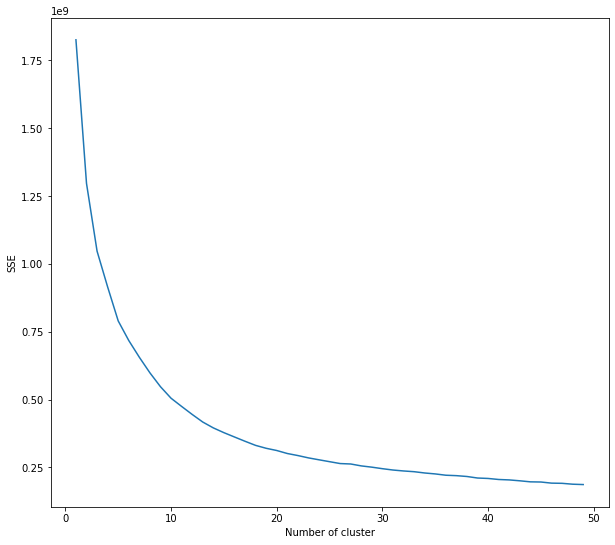

In [18]:
#AVALIANDO MELHOR NR DE CLUSTERS
sse = {}
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data_input_scaled)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure(figsize=(10,9))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [10]:
#DEFININDO NR DE CLUSTERS
k = 45

#ALGORITMO
kmeans = KMeans(n_clusters = k, random_state=0).fit(data_input_scaled)

cluster = kmeans.predict(data_input_scaled)
base_cluster['cluster'] = cluster
df['cluster'] = cluster


print("---------------VOLUMETRIA ------------------")
print(df['cluster'].value_counts())


---------------VOLUMETRIA ------------------
18    445462
32     37808
16     35194
34     18898
0      17666
35     15353
14     14636
6      10748
2       9935
3       6215
10      5136
7       4685
15      4316
23      3059
27      2714
31      1608
43      1480
21      1267
25      1080
41      1042
13       913
33       850
40       801
9        764
39       440
28       434
44       377
5        351
1        201
11       181
19       158
22       135
37       111
36       109
24       105
8         77
29        49
12        25
20        23
30        19
26        18
42        17
17        12
4          8
38         5
Name: cluster, dtype: int64


/tmp/ipykernel_125/3762484955.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_cluster['cluster'] = cluster


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


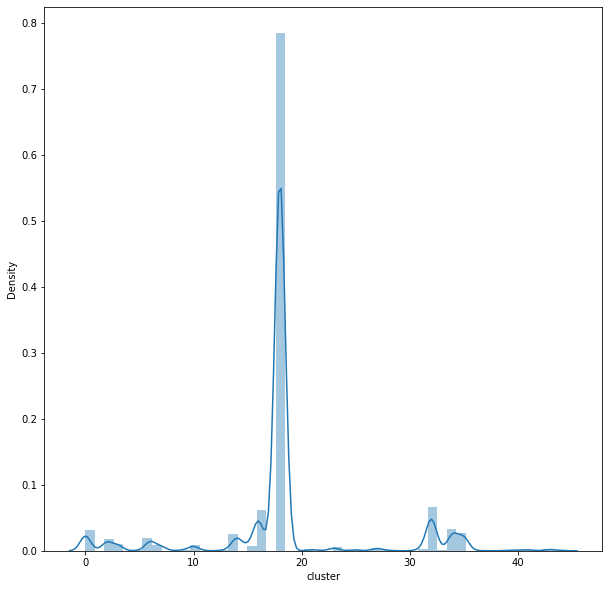

In [11]:
plt.figure(figsize=(10,10))
sns.distplot(df['cluster'])
plt.show()

In [12]:
print("---------------VOLUMETRIA ------------------")
print(df['cluster'].value_counts(normalize = True))

---------------VOLUMETRIA ------------------
18    0.691191
32    0.058664
16    0.054608
34    0.029323
0     0.027411
35    0.023822
14    0.022710
6     0.016677
2     0.015415
3     0.009643
10    0.007969
7     0.007269
15    0.006697
23    0.004746
27    0.004211
31    0.002495
43    0.002296
21    0.001966
25    0.001676
41    0.001617
13    0.001417
33    0.001319
40    0.001243
9     0.001185
39    0.000683
28    0.000673
44    0.000585
5     0.000545
1     0.000312
11    0.000281
19    0.000245
22    0.000209
37    0.000172
36    0.000169
24    0.000163
8     0.000119
29    0.000076
12    0.000039
20    0.000036
30    0.000029
26    0.000028
42    0.000026
17    0.000019
4     0.000012
38    0.000008
Name: cluster, dtype: float64


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(base_cluster[features_cluster]
                                                    , base_cluster['cluster']
                                                    , random_state=42, test_size=0.20)
arvores = [100, 300]
accuracy_array = []

for i in arvores:
  rf = RandomForestClassifier(n_estimators=i)
  rf.fit(x_train, y_train)
  y_predicted_rf = rf.predict(x_test)
  accuracy_rf = accuracy_score(y_test, y_predicted_rf).round(4)
  accuracy_array.append(accuracy_rf)
  print(i)
rf_estimators = pd.DataFrame(list(zip(arvores, accuracy_array)), columns =['arvores', 'acuracia'])
print("---------------ACURACCY CLASSIFICATION ------------")
rf_estimators['acuracia'].max()



100


In [ ]:
print("---------------IMPORTANCIA DAS FEATURES - O QUE MAIS PESOU NA CONSTRUÇÃO DOS GRUPOS? ------------")
best_rf = RandomForestClassifier(n_estimators= rf_estimators['arvores'][rf_estimators['acuracia'].idxmax()])
best_rf.fit(x_train, y_train)
importance_df = pd.DataFrame(best_rf.feature_importances_, columns = ['importancia'], index = features_cluster)
importance_df.sort_values(by='importancia', ascending=False).head(15).plot.bar(figsize=(20,5))


In [ ]:
features_importantes = importance_df.sort_values(by='importancia', ascending=False).head(20).index

In [ ]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: red' if v else '' for v in is_max]

print("---------------MEDIAS POR CLUSTER ------------")
cl_col = ['cluster']
totalfeat = features_cluster + cl_col
df[totalfeat].groupby('cluster').mean().style.apply(highlight_max)


In [ ]:
for i in features_importantes:
    print("---------------MEDIAS POR CLUSTER GRÁFICO ------------")
    print(i)
    plt.figure(figsize=(15,8))
    sns.lineplot(data = df[[i, 'cluster']].groupby('cluster').mean(), palette = 'Paired')
    plt.show()

## Lookalike para aquisição

In [4]:
query = '''

select s.* 
, o.ds_cbo_group
, g.nr_score_bvs
, g.nr_score_serasa_custom
, g.ds_last_disapproval_reason
, gc.nr_institutions
, gc.nr_operations
, gc.vl_util_market
from customer_sandbox_zone.segmentacao_digital_credito_flavia_total s
left join customer_curated_zone.ca_dict_occupations o on (o.ds_occupation = s.ds_occupation)
left join growth_curated_zone.proposal_analysis g on (g.cpf = s.cpf)
left join customer_curated_zone.ca_book_gestao_carteira gc on (g.cpf = gc.cpf 
								and date_trunc('month', g.dt_cfi_account) = date_trunc('month', gc.dt_base_scr) )
order by rand()
limit 500000

'''

In [5]:
df = ac.df_athena('flavia-costa', query)

In [6]:
df.head()

,cpf,tempo_relacionamento,ds_risk_type,gender,nr_declared_income,vl_limite_cartao,ds_region,ds_occupation,nm_current_os,ds_city_size,...,gr_mobilidade,gr_pix,ds_perfil_conexao,ds_cbo_group,nr_score_bvs,nr_score_serasa_custom,ds_last_disapproval_reason,nr_institutions,nr_operations,vl_util_market
0,70704410451,1650.0,2. Alto Risco,MALE,0.01,6800.0,Nordeste,OUTRO,android,None,...,A,A,Outros,OUTROS,667.0,NaN,None,NaN,NaN,NaN
1,04430686319,819.0,2. Alto Risco,FEMALE,4000.00,750.0,Nordeste,AUTÔNOMO,ios,pequeno,...,A,A,Outros,AUTÔNOMOS,617.0,NaN,NAO ATINGIU SCORE LONGO PRAZO,NaN,NaN,NaN
2,02840819490,1506.0,3. Medio Risco,MALE,0.01,700.0,Nordeste,SUPERVISOR DE EMPRESA,android,grande,...,A,C,Entusiasta Digital,"PROFISSIONAIS DAS CIÊNCIAS EXATAS, BIOLÓGICAS,...",NaN,NaN,NEGATIVADO SERASA,NaN,NaN,NaN
3,09615370436,779.0,2. Alto Risco,MALE,4800.00,NaN,Nordeste,Técnico(a) em Informática,android,pequeno,...,A,A,Outros,TÉCNICOS DE NIVEL MÉDIO,608.0,744.0,None,5.0,19.0,NaN
4,05254778377,161.0,3. Medio Risco,FEMALE,2000.00,360.0,Nordeste,Repositor,android,pequeno,...,A,B,Digital Moderado,"TRABALHADORES DOS SERVIÇOS, VENDEDORES DO COMÉ...",629.0,603.0,NAO ATINGIU SCORE LONGO PRAZO,NaN,NaN,NaN


In [7]:
df.ds_perfil_conexao.value_counts()

Outros                          392684
Entusiasta Digital               47662
Digital Moderado                 25292
Gastador Digital Estratégico     23973
Comprador Digital Móvel          10389
Name: ds_perfil_conexao, dtype: int64

In [8]:
df.columns

Index(['cpf', 'tempo_relacionamento', 'ds_risk_type', 'gender',
       'nr_declared_income', 'vl_limite_cartao', 'ds_region', 'ds_occupation',
       'nm_current_os', 'ds_city_size', 'dt_nascimento', 'nr_days_fpd',
       'ds_schooling', 'flag_autonomo', 'nr_trans_pix',
       'nr_antecipacao_fatura', 'flag_bolso', 'nr_purchases_virtual',
       'avg_vl_total_spending', 'nr_purchases_online',
       'nr_purchases_contactless', 'nr_recarga_credito', 'nr_acessos',
       'pc_acessos_lojawill', 'nr_pagamentos_conta',
       'nr_pagamentos_conta_credito', 'trans_recorrente',
       'trans_mobilidade_app', 'trans_delivery', 'trans_recarga_geral',
       'trans_streaming', 'trans_rede_social', 'trans_games', 'trans_cripto',
       'ds_cluster_sociodemographic', 'gr_virtual', 'gr_online',
       'gr_contactless', 'gr_mobilidade', 'gr_pix', 'ds_perfil_conexao'],
      dtype='object')

In [10]:
df.dtypes

cpf                             object
tempo_relacionamento           float64
ds_risk_type                    object
gender                          object
nr_declared_income             float64
vl_limite_cartao               float64
ds_region                       object
ds_occupation                   object
nm_current_os                   object
ds_city_size                    object
dt_nascimento                  float64
nr_days_fpd                    float64
ds_schooling                    object
flag_autonomo                    int64
nr_trans_pix                   float64
nr_antecipacao_fatura          float64
flag_bolso                       int64
nr_purchases_virtual           float64
avg_vl_total_spending          float64
nr_purchases_online            float64
nr_purchases_contactless       float64
nr_recarga_credito             float64
nr_acessos                     float64
pc_acessos_lojawill            float64
nr_pagamentos_conta            float64
nr_pagamentos_conta_credi

In [8]:
# defining types
id_columns = ['cpf']
cat_columns = df.drop(id_columns, axis = 1).select_dtypes('string').columns
num_columns = df.drop(id_columns, axis = 1).select_dtypes(exclude=['string']).columns

#defining roles
preditores_dummie = ['gender',	'ds_region', 'ds_cbo_group', 'nm_current_os', 'ds_city_size', 'ds_schooling', 'ds_last_disapproval_reason'] 
target = ['ds_perfil_conexao']


#missings
df.isnull().sum()

cpf                                 0
tempo_relacionamento             3391
ds_risk_type                        0
gender                           3940
nr_declared_income                  0
vl_limite_cartao               202970
ds_region                           1
ds_occupation                       0
nm_current_os                   29706
ds_city_size                    23818
dt_nascimento                     148
nr_days_fpd                     59874
ds_schooling                      153
flag_autonomo                       0
nr_trans_pix                   232101
nr_antecipacao_fatura          232101
flag_bolso                          0
nr_purchases_virtual           182315
avg_vl_total_spending          182315
nr_purchases_online            182315
nr_purchases_contactless       182315
nr_recarga_credito             193876
nr_acessos                     231045
pc_acessos_lojawill            231045
nr_pagamentos_conta            231045
nr_pagamentos_conta_credito    231045
trans_recorr

In [9]:
df['ds_last_disapproval_reason'].fillna('ni', inplace = True)

In [85]:
df['ds_last_disapproval_reason'].value_counts()

ni                                                                    356653
NAO ATINGIU SCORE SERASA                                               31654
NAO ATINGIU SCORE LONGO PRAZO                                          26830
NEGATIVADO SERASA                                                      16631
NAO ATINGIU SCORE SUFICIENTE                                           14583
NAO ATINGIU SCORE CURTO PRAZO                                          13936
NAO ATINGIU SCORE BVS                                                  12509
CEL NUMERO SEM WHATSAPP                                                 9354
NEGATIVADO BVS                                                          7309
LISTA INTERNA DE REPROVACAO                                             3695
CPF INATIVO                                                             1375
FRAUDE DOCUMENTOS                                                        930
REPROVADO PELO MOTOR DE FRAUDE                                           666

In [10]:
for column in df.columns:
    if df[column].dtype == 'object':
        df[column].fillna(df[column].mode()[0], inplace = True)
    elif df[column].dtype == 'string':
        df[column].fillna(df[column].mode()[0], inplace = True)
    elif df[column].dtype != 'object':
        df[column].fillna(0.0, inplace = True)

In [11]:
df_model = pd.get_dummies(df, columns=preditores_dummie)

In [65]:
df_model.columns

Index(['cpf', 'tempo_relacionamento', 'ds_risk_type', 'nr_declared_income',
       'vl_limite_cartao', 'ds_occupation', 'dt_nascimento', 'nr_days_fpd',
       'flag_autonomo', 'nr_trans_pix',
       ...
       'ds_last_disapproval_reason_NUMERO DE REGISTRO DA CNH DIVERGENTE DO DOCUMENTO DE IDENTIFICAÇÃO',
       'ds_last_disapproval_reason_NUMERO DE RG DIVERGENTE DO DOCUMENTO DE IDENTIFICAÇÃO',
       'ds_last_disapproval_reason_NÃO CONFERE TRABALHO',
       'ds_last_disapproval_reason_PROBLEMAS NA BIOMETRIA',
       'ds_last_disapproval_reason_PROPOSTA NAO PREENCHIDA COMPLETAMENTE',
       'ds_last_disapproval_reason_PROVA DE VIDA COM DIVERGENCIA',
       'ds_last_disapproval_reason_REPROVADO PELO MOTOR DE FRAUDE',
       'ds_last_disapproval_reason_UF DA CNH DIVERGENTE',
       'ds_last_disapproval_reason_UF DO RG DIVERGENTE',
       'ds_last_disapproval_reason_ni'],
      dtype='object', length=127)

In [69]:
df_model.T.tail(50
                )

,0,1,2,3,4,5,6,7,8,9,...,499990,499991,499992,499993,499994,499995,499996,499997,499998,499999
ds_schooling_INCOMPLETE_MASTER,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ds_schooling_INCOMPLETE_POST_GRADUATE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ds_schooling_OTHER,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ds_last_disapproval_reason_ANTECEDENTES CRIMINAIS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ds_last_disapproval_reason_ATINGIU O LIMITE DE PENDÊNCIA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ds_last_disapproval_reason_CEL NUMERO SEM WHATSAPP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ds_last_disapproval_reason_CEP AREA DE RISCO FLASH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ds_last_disapproval_reason_CEP ENTREGA DIFERENCIADO,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ds_last_disapproval_reason_CEP ENTREGA INTERNA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ds_last_disapproval_reason_CEP INVALIDO,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
preditores_finais = [
'nr_score_bvs', 'nr_score_serasa_custom',
'nr_institutions', 'nr_operations', 'vl_util_market',
"nr_declared_income",
"gender_FEMALE",
"gender_MALE",
"ds_region_Centro-Oeste",
"ds_region_Nordeste",
"ds_region_Norte",
"ds_region_Sudeste",
"ds_region_Sul",
"nm_current_os_android",
"nm_current_os_ios",
"ds_city_size_grande",
"ds_city_size_medio",
"ds_city_size_pequeno",
"ds_schooling_COMPLETE_DOCTORATE",
"ds_schooling_COMPLETE_ELEMENTARY",
"ds_schooling_COMPLETE_HIGHER_EDUCATION",
"ds_schooling_COMPLETE_HIGH_SCHOOL",
"ds_schooling_COMPLETE_MASTER",
"ds_schooling_COMPLETE_POST_GRADUATE",
"ds_schooling_INCOMPLETE_DOCTORATE",
"ds_schooling_INCOMPLETE_ELEMENTARY",
"ds_schooling_INCOMPLETE_HIGHER_EDUCATION",
"ds_schooling_INCOMPLETE_HIGH_SCHOOL",
"ds_schooling_INCOMPLETE_MASTER",
"ds_schooling_INCOMPLETE_POST_GRADUATE",
"ds_schooling_OTHER",
'ds_cbo_group_APOSENTADOS', 'ds_cbo_group_AUTÔNOMOS',
 'ds_cbo_group_DONAS DE CASA', 'ds_cbo_group_ESTUDANTES',
 'ds_cbo_group_MEMBROS DAS FORÇAS ARMADAS, POLICIAIS E BOMBEIROS MILITARES',
'ds_cbo_group_MEMBROS SUPERIORES DO PODER PÚBLICO, DIRIGENTES DE ORGANIZAÇÕES DE INTERESSE PÚBLICO E DE EMPRESAS, GERENTES',
 'ds_cbo_group_OUTROS',
'ds_cbo_group_PROFISSIONAIS DAS CIÊNCIAS EXATAS, BIOLÓGICAS, HUMANAS E DAS ARTES',
'ds_cbo_group_TRABALHADORES AGROPECUÁRIOS, FLORESTAIS E DA PESCA',
'ds_cbo_group_TRABALHADORES DA PRODUÇÃO DE BENS E SERVIÇOS INDUSTRIAIS',
'ds_cbo_group_TRABALHADORES DE SERVIÇOS ADMINISTRATIVOS',
'ds_cbo_group_TRABALHADORES DOS SERVIÇOS, VENDEDORES DO COMÉRCIO EM LOJAS E MERCADOS',
'ds_cbo_group_TRABALHADORES EM SERVIÇOS DE REPARAÇÃO E MANUTENÇÃO',
'ds_cbo_group_TÉCNICOS DE NIVEL MÉDIO',
"ds_last_disapproval_reason_ni",
"ds_last_disapproval_reason_NAO ATINGIU SCORE SERASA",
"ds_last_disapproval_reason_NEGATIVADO SERASA",
"ds_last_disapproval_reason_NAO ATINGIU SCORE SUFICIENTE",
"ds_last_disapproval_reason_NAO ATINGIU SCORE CURTO PRAZO",
"ds_last_disapproval_reason_NAO ATINGIU SCORE BVS",
"ds_last_disapproval_reason_CEL NUMERO SEM WHATSAPP",
"ds_last_disapproval_reason_NEGATIVADO BVS",
"ds_last_disapproval_reason_LISTA INTERNA DE REPROVACAO",
"ds_last_disapproval_reason_CPF INATIVO",
"ds_last_disapproval_reason_FRAUDE DOCUMENTOS"
]

Pegar apenas 20% dos outros para balancear a amostra

In [13]:
df_model['aleat'] = np.random.random((len(df),1))

In [14]:
df_model['novo_target'] = np.where((df_model['ds_perfil_conexao'] == 'Outros') & (df_model['aleat'] <= 0.10), 4,
                          np.where((df_model['ds_perfil_conexao'] == 'Outros') & (df_model['aleat'] > 0.10), 5,         
                          np.where(df_model['ds_perfil_conexao'] == 'Entusiasta Digital', 1,  
                          np.where(df_model['ds_perfil_conexao'] == 'Digital Moderado', 2,
                          np.where(df_model['ds_perfil_conexao'] == 'Gastador Digital Estratégico', 3,
                           0 )))))

df_model['novo_target'].value_counts()

5    353431
1     47662
4     39253
2     25292
3     23973
0     10389
Name: novo_target, dtype: int64

In [15]:
df_model_b = df_model.query('novo_target <5')

df_model_b['novo_target'].value_counts()

1    47662
4    39253
2    25292
3    23973
0    10389
Name: novo_target, dtype: int64

#### Modelo para identificar grupos digitais

In [97]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_model_b[preditores_finais]
                                                    , df_model_b['novo_target']
                                                    , random_state=42, test_size=0.20)

/home/flavia.costa/.local/lib/python3.8/site-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


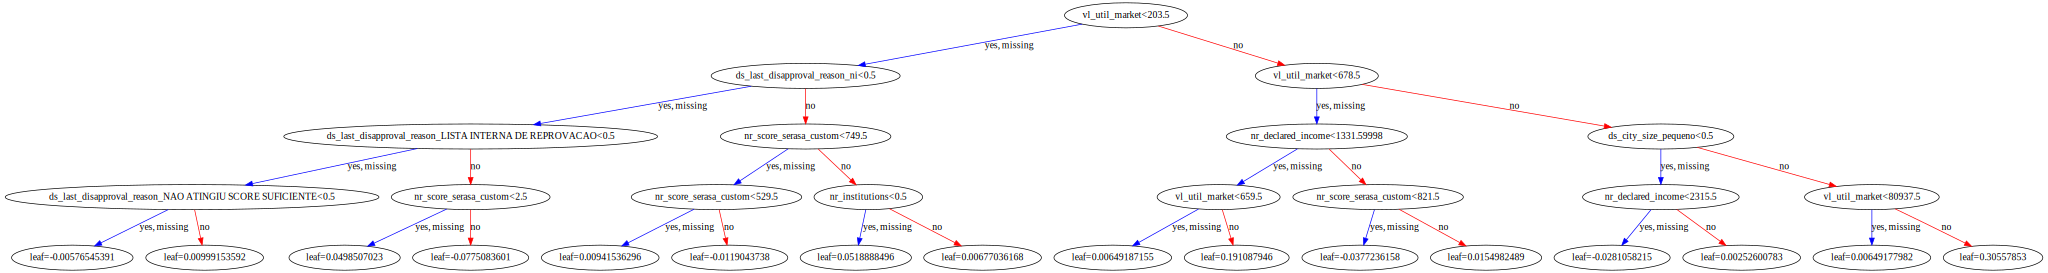

In [98]:
import xgboost as xgb

clf = xgb.XGBClassifier("multi:softprob", max_depth=4, random_state=42) 
clf.fit(x_train, y_train)
#arvore de decisão
import graphviz
xgb.to_graphviz(clf, num_trees=clf.best_iteration)

In [99]:
y_predicted = clf.predict(x_test)

In [100]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.38      0.21      0.27      2043
           1       0.45      0.73      0.56      9594
           2       0.29      0.01      0.02      5067
           3       0.46      0.42      0.44      4716
           4       0.40      0.42      0.41      7913

    accuracy                           0.44     29333
   macro avg       0.40      0.36      0.34     29333
weighted avg       0.41      0.44      0.39     29333



#### Performance Ruim - Modelo para identificar qualquer um dos grupos digitais

unificando targets - grupos digitais x outros

In [16]:
df_model_b['flag_digitais'] = np.where(df_model_b['novo_target'] == 4, 0, 1)

df_model_b['flag_digitais'].value_counts()

/tmp/ipykernel_163386/3395420671.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_b['flag_digitais'] = np.where(df_model_b['novo_target'] == 4, 0, 1)


1    107316
0     39253
Name: flag_digitais, dtype: int64

In [191]:
x_train, x_test, y_train, y_test = train_test_split(df_model_b[preditores_finais]
                                                    , df_model_b['flag_digitais']
                                                    , random_state=42, test_size=0.20)

/home/flavia.costa/.local/lib/python3.8/site-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


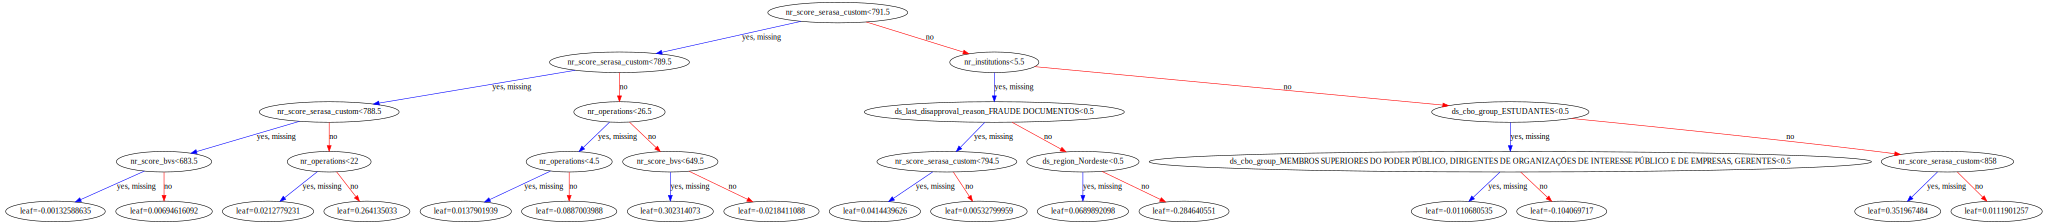

In [192]:
clf = xgb.XGBClassifier("binary:logistic", max_depth=4, random_state=42) 
clf.fit(x_train, y_train)
#arvore de decisão
import graphviz
xgb.to_graphviz(clf, num_trees=clf.best_iteration)

In [193]:
y_predicted = clf.predict(x_test)

In [194]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.52      0.06      0.12      7913
           1       0.74      0.98      0.84     21420

    accuracy                           0.73     29333
   macro avg       0.63      0.52      0.48     29333
weighted avg       0.68      0.73      0.65     29333



Permutation explainer: 29334it [20:51, 23.27it/s]                             
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


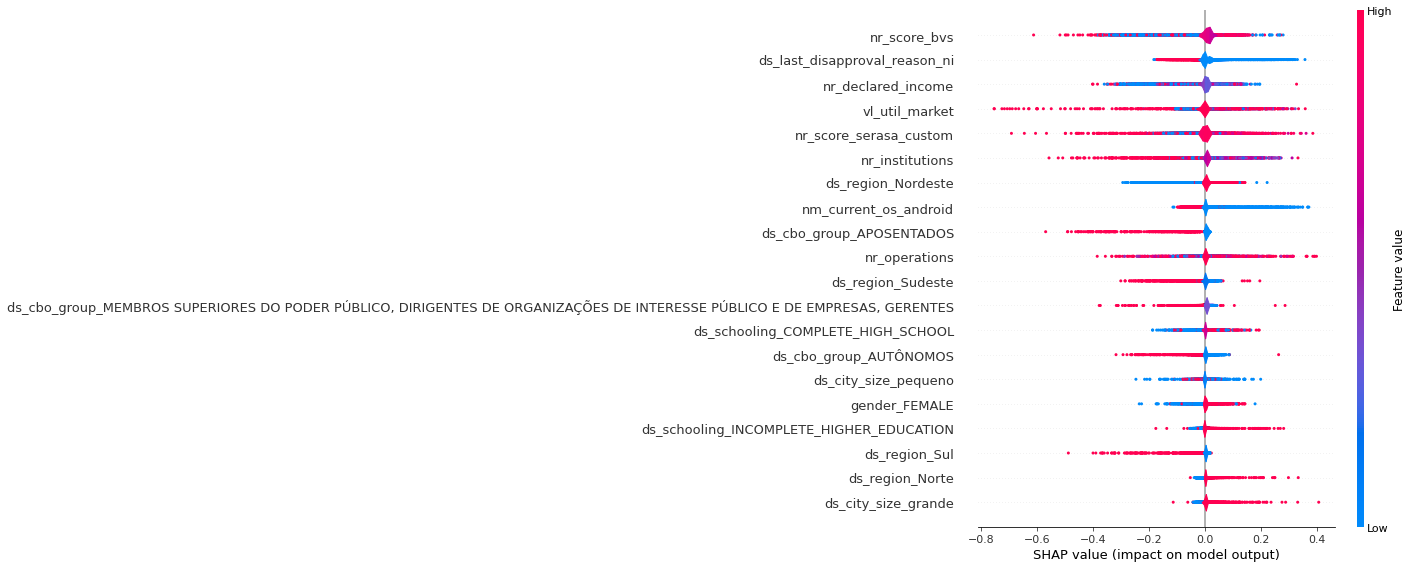

In [195]:
import shap

explainer = shap.Explainer(clf.predict, x_test)
shap_values = explainer(x_test)
shap.summary_plot(shap_values, plot_type='violin')

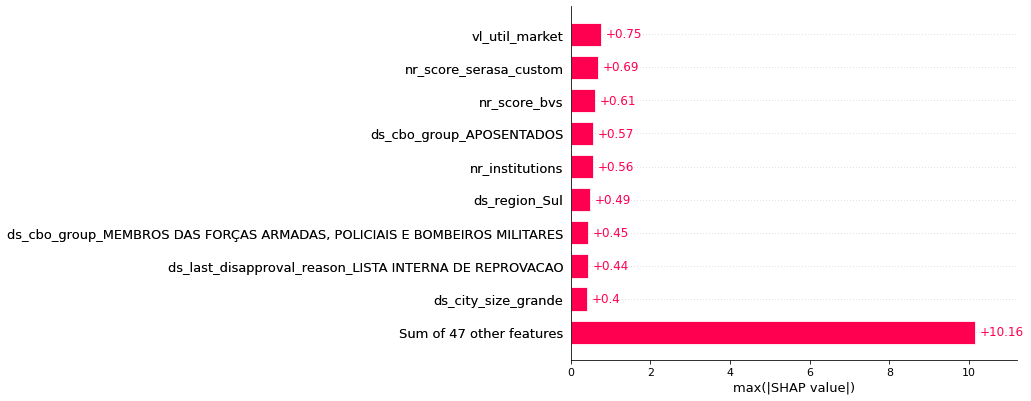

In [199]:
shap.plots.bar(shap_values.abs.max(0))

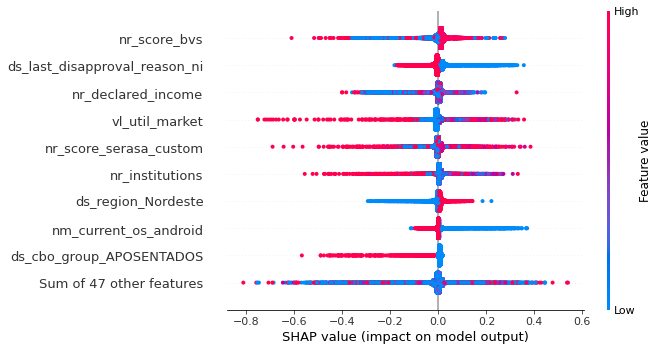

In [196]:
shap.plots.beeswarm(shap_values)

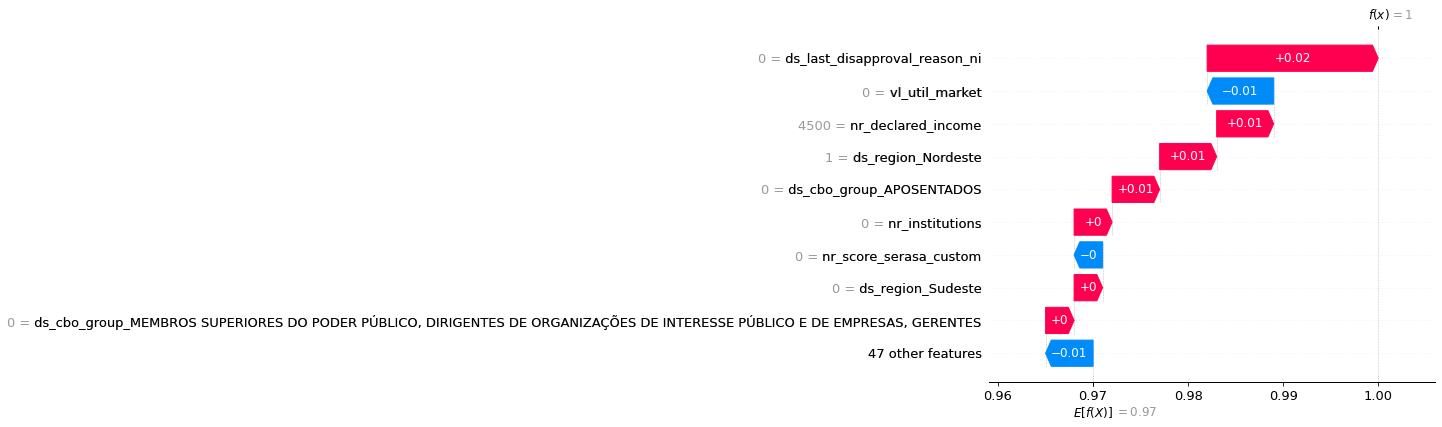

In [197]:
shap.plots.waterfall(shap_values[0])

In [198]:
shap.initjs()
shap.plots.force(shap_values[0])

#### Modelo apenas com digitais para identificar grupos

In [17]:
df_model_c = df_model_b.query('novo_target <4')

df_model_c['novo_target'].value_counts()

1    47662
2    25292
3    23973
0    10389
Name: novo_target, dtype: int64

In [108]:
df['ds_perfil_conexao'].value_counts()

Outros                          392702
Entusiasta Digital               47976
Digital Moderado                 25203
Gastador Digital Estratégico     23755
Comprador Digital Móvel          10364
Name: ds_perfil_conexao, dtype: int64

In [109]:
x_train, x_test, y_train, y_test = train_test_split(df_model_c[preditores_finais]
                                                    , df_model_c['novo_target']
                                                    , random_state=42, test_size=0.20)

/home/flavia.costa/.local/lib/python3.8/site-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


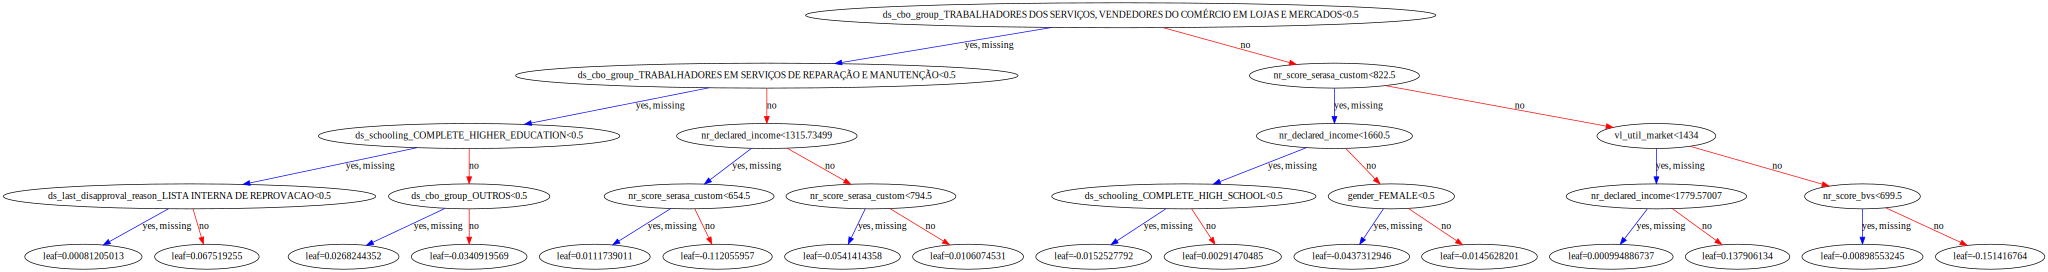

In [110]:
clf = xgb.XGBClassifier("multi:softprob", max_depth=4, random_state=42) 
clf.fit(x_train, y_train)
#arvore de decisão
import graphviz
xgb.to_graphviz(clf, num_trees=clf.best_iteration)

In [111]:
y_predicted = clf.predict(x_test)

In [112]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.46      0.27      0.34      2137
           1       0.54      0.84      0.66      9624
           2       0.39      0.04      0.07      4959
           3       0.59      0.61      0.60      4740

    accuracy                           0.55     21460
   macro avg       0.49      0.44      0.42     21460
weighted avg       0.51      0.55      0.48     21460



#### Criando segmentações para serem aplicadas em toda a base

##### Segmentação para identificar algum grupo digital

In [18]:
df['fx1_serasa'] = np.where(df['nr_score_serasa_custom'] < 788.5, 'Serasa até 788',
                   np.where(df['nr_score_serasa_custom'] < 791.5, 'Serasa >788-790',        
                   np.where(df['nr_score_serasa_custom'] < 794.5, 'Serasa >790-794',
                    np.where(df['nr_score_serasa_custom'] < 858.0, 'Serasa >794-857', 'Serasa >857' 
                            ))))

df['fx1_serasa'].value_counts()

Serasa até 788     428424
Serasa >794-857     49348
Serasa >857         10477
Serasa >788-790      6139
Serasa >790-794      5612
Name: fx1_serasa, dtype: int64

In [19]:
df['flag_if'] = np.where(df['nr_institutions'] < 5.5, 'Até 5 IFs', 'Mais de 5 IFs')

df['flag_if'].value_counts()

Até 5 IFs        469527
Mais de 5 IFs     30473
Name: flag_if, dtype: int64

In [20]:
df['fx1_operations'] = np.where(df['nr_operations'] < 4.5, 'Até 4 Operacoes',
                   np.where(df['nr_score_serasa_custom'] < 22, 'Mais de 4-21 Operacoes',        
                   np.where(df['nr_score_serasa_custom'] < 26.5, 'Mais de 21-26 Operacoes', 'Mais de 26 Operacoes')))

df['fx1_operations'].value_counts()

Até 4 Operacoes           392876
Mais de 26 Operacoes       94069
Mais de 4-21 Operacoes     13055
Name: fx1_operations, dtype: int64

In [21]:
df['fx1_bvs'] = np.where(df['nr_score_bvs'] < 649.5, 'BVS Até 649',
                   np.where(df['nr_score_bvs'] < 683.5, 'BVS >649-683', 'BVS >683'))

df['fx1_bvs'].value_counts()

BVS Até 649     274249
BVS >649-683    160183
BVS >683         65568
Name: fx1_bvs, dtype: int64

In [117]:
df.columns

Index(['cpf', 'tempo_relacionamento', 'ds_risk_type', 'gender',
       'nr_declared_income', 'vl_limite_cartao', 'ds_region', 'ds_occupation',
       'nm_current_os', 'ds_city_size', 'dt_nascimento', 'nr_days_fpd',
       'ds_schooling', 'flag_autonomo', 'nr_trans_pix',
       'nr_antecipacao_fatura', 'flag_bolso', 'nr_purchases_virtual',
       'avg_vl_total_spending', 'nr_purchases_online',
       'nr_purchases_contactless', 'nr_recarga_credito', 'nr_acessos',
       'pc_acessos_lojawill', 'nr_pagamentos_conta',
       'nr_pagamentos_conta_credito', 'trans_recorrente',
       'trans_mobilidade_app', 'trans_delivery', 'trans_recarga_geral',
       'trans_streaming', 'trans_rede_social', 'trans_games', 'trans_cripto',
       'ds_cluster_sociodemographic', 'gr_virtual', 'gr_online',
       'gr_contactless', 'gr_mobilidade', 'gr_pix', 'ds_perfil_conexao',
       'ds_cbo_group', 'nr_score_bvs', 'nr_score_serasa_custom',
       'ds_last_disapproval_reason', 'nr_institutions', 'nr_operation

In [120]:
df['ds_last_disapproval_reason'].value_counts()

ni                                                                    356653
NAO ATINGIU SCORE SERASA                                               31654
NAO ATINGIU SCORE LONGO PRAZO                                          26830
NEGATIVADO SERASA                                                      16631
NAO ATINGIU SCORE SUFICIENTE                                           14583
NAO ATINGIU SCORE CURTO PRAZO                                          13936
NAO ATINGIU SCORE BVS                                                  12509
CEL NUMERO SEM WHATSAPP                                                 9354
NEGATIVADO BVS                                                          7309
LISTA INTERNA DE REPROVACAO                                             3695
CPF INATIVO                                                             1375
FRAUDE DOCUMENTOS                                                        930
REPROVADO PELO MOTOR DE FRAUDE                                           666

In [22]:
df['flag_nordeste'] = np.where(df['ds_region'] == 'Nordeste', 'Nordeste', 'Outras Regiões')
df['flag_nordeste'].value_counts()

Nordeste          293599
Outras Regiões    206401
Name: flag_nordeste, dtype: int64

In [23]:
df['flag_fraude_docs'] = np.where(df['ds_last_disapproval_reason'] == 'FRAUDE DOCUMENTOS', 'Desaprov. Fraude Docs', 'Sem Desaprov ou Outros')
df['flag_fraude_docs'].value_counts()

Sem Desaprov ou Outros    499070
Desaprov. Fraude Docs        930
Name: flag_fraude_docs, dtype: int64

In [123]:
df['seg_grupos_1'] = df['fx1_serasa'] + ' - ' + df['flag_if'] + ' - ' + df['fx1_operations']  + ' - ' + df['fx1_bvs'] + ' - ' + df['flag_nordeste'] + ' - ' + df['flag_fraude_docs'] 

In [124]:
df['seg_grupos_1'].value_counts()

Serasa até 788 - Até 5 IFs - Até 4 Operacoes - BVS Até 649 - Nordeste - Sem Desaprov ou Outros           130860
Serasa até 788 - Até 5 IFs - Até 4 Operacoes - BVS Até 649 - Outras Regiões - Sem Desaprov ou Outros      96183
Serasa até 788 - Até 5 IFs - Até 4 Operacoes - BVS >649-683 - Nordeste - Sem Desaprov ou Outros           67147
Serasa até 788 - Até 5 IFs - Até 4 Operacoes - BVS >649-683 - Outras Regiões - Sem Desaprov ou Outros     34717
Serasa até 788 - Até 5 IFs - Até 4 Operacoes - BVS >683 - Nordeste - Sem Desaprov ou Outros               23539
                                                                                                          ...  
Serasa >790-794 - Até 5 IFs - Até 4 Operacoes - BVS >683 - Nordeste - Desaprov. Fraude Docs                   1
Serasa >857 - Até 5 IFs - Até 4 Operacoes - BVS Até 649 - Outras Regiões - Desaprov. Fraude Docs              1
Serasa >788-790 - Até 5 IFs - Até 4 Operacoes - BVS >683 - Outras Regiões - Desaprov. Fraude Docs       

In [30]:
df['flag_perfis_conexao'] = np.where(df['ds_perfil_conexao'] == 'Outros', 0, 1)
df['flag_perfis_conexao'].value_counts(normalize=True)

0    0.785368
1    0.214632
Name: flag_perfis_conexao, dtype: float64

In [36]:
pd.crosstab(df['ds_last_disapproval_reason'], df['flag_perfis_conexao'], normalize='index')

flag_perfis_conexao,0,1
ds_last_disapproval_reason,,
ATINGIU O LIMITE DE PENDÊNCIA,0.685714,0.314286
CEL NUMERO SEM WHATSAPP,0.700351,0.299649
CEP AREA DE RISCO FLASH,0.658537,0.341463
CEP ENTREGA DIFERENCIADO,0.745614,0.254386
CEP ENTREGA INTERNA,0.699029,0.300971
CEP INVALIDO,1.000000,0.000000
CPF INATIVO,0.672062,0.327938
CPF INEXISTENTE,0.820639,0.179361
CPF NÃO ENCONTRADO NO BUREAU DE CONSULTA,0.000000,1.000000


In [131]:
df_grupos1  = pd.crosstab(df['seg_grupos_1'], df['flag_perfis_conexao'], normalize='index')

df_grupos1 = df_grupos1.reset_index()
df_grupos1.columns = ['seg_grupos_1', 'perc_outros', 'perc_grupos_conexao']

df_grupos1

,seg_grupos_1,perc_outros,perc_grupos_conexao
0,Serasa >788-790 - Até 5 IFs - Até 4 Operacoes ...,0.000000,1.000000
1,Serasa >788-790 - Até 5 IFs - Até 4 Operacoes ...,0.768036,0.231964
2,Serasa >788-790 - Até 5 IFs - Até 4 Operacoes ...,1.000000,0.000000
3,Serasa >788-790 - Até 5 IFs - Até 4 Operacoes ...,0.796820,0.203180
4,Serasa >788-790 - Até 5 IFs - Até 4 Operacoes ...,1.000000,0.000000
...,...,...,...
124,Serasa até 788 - Mais de 5 IFs - Mais de 4-21 ...,0.907246,0.092754
125,Serasa até 788 - Mais de 5 IFs - Mais de 4-21 ...,0.877551,0.122449
126,Serasa até 788 - Mais de 5 IFs - Mais de 4-21 ...,0.926829,0.073171
127,Serasa até 788 - Mais de 5 IFs - Mais de 4-21 ...,0.835303,0.164697


In [137]:
df_grupos1.describe()

,perc_outros,perc_grupos_conexao
count,129.000000,129.000000
mean,0.804381,0.195619
std,0.148813,0.148813
min,0.000000,0.000000
25%,0.783333,0.139918
50%,0.830986,0.169014
75%,0.860082,0.216667
max,1.000000,1.000000


In [138]:
df_grupos1.query('perc_grupos_conexao > 0.22')

,seg_grupos_1,perc_outros,perc_grupos_conexao
0,Serasa >788-790 - Até 5 IFs - Até 4 Operacoes ...,0.000000,1.000000
1,Serasa >788-790 - Até 5 IFs - Até 4 Operacoes ...,0.768036,0.231964
6,Serasa >788-790 - Até 5 IFs - Até 4 Operacoes ...,0.000000,1.000000
9,Serasa >788-790 - Até 5 IFs - Até 4 Operacoes ...,0.676790,0.323210
10,Serasa >788-790 - Até 5 IFs - Até 4 Operacoes ...,0.752660,0.247340
15,Serasa >788-790 - Até 5 IFs - Mais de 26 Opera...,0.700809,0.299191
23,Serasa >790-794 - Até 5 IFs - Até 4 Operacoes ...,0.000000,1.000000
24,Serasa >790-794 - Até 5 IFs - Até 4 Operacoes ...,0.721127,0.278873
25,Serasa >790-794 - Até 5 IFs - Até 4 Operacoes ...,0.666667,0.333333
31,Serasa >790-794 - Até 5 IFs - Até 4 Operacoes ...,0.741007,0.258993


Tirando as operações

In [139]:
df['seg_grupos_2'] = df['fx1_serasa'] + ' - ' + df['flag_if'] + ' - ' + df['fx1_bvs'] + ' - ' + df['flag_nordeste'] + ' - ' + df['flag_fraude_docs'] 

In [140]:
df_grupos2  = pd.crosstab(df['seg_grupos_2'], df['flag_perfis_conexao'], normalize='index')

df_grupos2 = df_grupos2.reset_index()
df_grupos2.columns = ['seg_grupos_2', 'perc_outros', 'perc_grupos_conexao']

df_grupos2

,seg_grupos_2,perc_outros,perc_grupos_conexao
0,Serasa >788-790 - Até 5 IFs - BVS >649-683 - N...,0.000000,1.000000
1,Serasa >788-790 - Até 5 IFs - BVS >649-683 - N...,0.776350,0.223650
2,Serasa >788-790 - Até 5 IFs - BVS >649-683 - O...,1.000000,0.000000
3,Serasa >788-790 - Até 5 IFs - BVS >649-683 - O...,0.808023,0.191977
4,Serasa >788-790 - Até 5 IFs - BVS >683 - Norde...,1.000000,0.000000
...,...,...,...
82,Serasa até 788 - Mais de 5 IFs - BVS >649-683 ...,0.872180,0.127820
83,Serasa até 788 - Mais de 5 IFs - BVS >683 - No...,0.851767,0.148233
84,Serasa até 788 - Mais de 5 IFs - BVS >683 - Ou...,0.889535,0.110465
85,Serasa até 788 - Mais de 5 IFs - BVS Até 649 -...,0.825724,0.174276


In [207]:
pd.crosstab(df['fx1_bvs'], df['flag_perfis_conexao'], normalize='index')

flag_perfis_conexao,0,1
fx1_bvs,,
BVS >649-683,0.778274,0.221726
BVS >683,0.830155,0.169845
BVS Até 649,0.778973,0.221027


In [208]:
pd.crosstab(df['fx1_serasa'], df['flag_perfis_conexao'], normalize='index')

flag_perfis_conexao,0,1
fx1_serasa,,
Serasa >788-790,0.794444,0.205556
Serasa >790-794,0.787609,0.212391
Serasa >794-857,0.797935,0.202065
Serasa >857,0.842628,0.157372
Serasa até 788,0.782392,0.217608


In [214]:
pd.crosstab(df['fx2_vl_market'], df['flag_perfis_conexao'], normalize='index')

flag_perfis_conexao,0,1
fx2_vl_market,,
Utilizado mercado acima de R$1434,0.819910,0.180090
Utilizado mercado até R$1434,0.780799,0.219201


In [141]:
df_grupos2.describe()

,perc_outros,perc_grupos_conexao
count,87.000000,87.000000
mean,0.796701,0.203299
std,0.177531,0.177531
min,0.000000,0.000000
25%,0.766225,0.130013
50%,0.830986,0.169014
75%,0.869987,0.233775
max,1.000000,1.000000


In [142]:
df_grupos2.query('perc_grupos_conexao >= 0.23')

,seg_grupos_2,perc_outros,perc_grupos_conexao
0,Serasa >788-790 - Até 5 IFs - BVS >649-683 - N...,0.000000,1.000000
6,Serasa >788-790 - Até 5 IFs - BVS >683 - Outra...,0.000000,1.000000
9,Serasa >788-790 - Até 5 IFs - BVS Até 649 - No...,0.687500,0.312500
17,Serasa >790-794 - Até 5 IFs - BVS >649-683 - N...,0.000000,1.000000
18,Serasa >790-794 - Até 5 IFs - BVS >649-683 - N...,0.741327,0.258673
19,Serasa >790-794 - Até 5 IFs - BVS >649-683 - O...,0.666667,0.333333
25,Serasa >790-794 - Até 5 IFs - BVS Até 649 - No...,0.747051,0.252949
34,Serasa >794-857 - Até 5 IFs - BVS >649-683 - N...,0.703704,0.296296
35,Serasa >794-857 - Até 5 IFs - BVS >649-683 - N...,0.755105,0.244895
36,Serasa >794-857 - Até 5 IFs - BVS >649-683 - O...,0.750000,0.250000


In [144]:
df_grupos2.query('perc_grupos_conexao >= 0.23').to_csv('propensao_proposta_gr_digitais.csv', index=False)

SIMPLIFICANDO AS REGRAS ANALISADAS

In [35]:
df['teste_prop_digitais'] = np.where((df.nr_score_serasa_custom >= 600) &  (df.nr_institutions <= 5) & (df.ds_region == 'Nordeste'), 1, 0)
# &(df.ds_region == 'Nordeste')
print(classification_report(df.flag_perfis_conexao, df.teste_prop_digitais))

              precision    recall  f1-score   support

           0       0.79      0.82      0.81    392684
           1       0.25      0.22      0.23    107316

    accuracy                           0.69    500000
   macro avg       0.52      0.52      0.52    500000
weighted avg       0.68      0.69      0.68    500000



In [ ]:
df['teste_prop_digitais'].value_counts(normalize=True)

0    0.811926
1    0.188074
Name: teste_prop_digitais, dtype: float64

In [190]:
pd.crosstab(df['teste_prop_digitais'], df['flag_perfis_conexao'], normalize='index')

flag_perfis_conexao,0,1
teste_prop_digitais,,
0,0.793526,0.206474
1,0.750343,0.249657


In [34]:
df['teste_prop_digitais2'] = np.where((df['teste_prop_digitais'] == 1) | (df.nr_score_bvs < 649) | (df.vl_util_market < 1434) , 1, 0)
# &(df.ds_region == 'Nordeste')
print(classification_report(df.flag_perfis_conexao, df.teste_prop_digitais2))

              precision    recall  f1-score   support

           0       0.85      0.05      0.10    392684
           1       0.22      0.96      0.36    107316

    accuracy                           0.25    500000
   macro avg       0.53      0.51      0.23    500000
weighted avg       0.71      0.25      0.16    500000



In [32]:
pd.crosstab(df['teste_prop_digitais2'], df['flag_perfis_conexao'], normalize='index')

flag_perfis_conexao,0,1
teste_prop_digitais2,,
0,0.847195,0.152805
1,0.782086,0.217914


In [31]:
df['teste_prop_digitais3'] = np.where((df.nr_score_bvs < 649) & (df.vl_util_market < 1434) & (df.nr_institutions < 5) & (df.nr_score_serasa_custom > 790), 1, 0)
# &(df.ds_region == 'Nordeste')
print(classification_report(df.flag_perfis_conexao, df.teste_prop_digitais3))

              precision    recall  f1-score   support

           0       0.79      0.98      0.87    392684
           1       0.23      0.02      0.03    107316

    accuracy                           0.78    500000
   macro avg       0.51      0.50      0.45    500000
weighted avg       0.67      0.78      0.69    500000



In [33]:
df['teste_prop_digitais4'] = np.where((df.nr_score_bvs < 649) & (df.nr_institutions < 5) & (df.nr_score_serasa_custom > 790), 1, 0)

print(classification_report(df.flag_perfis_conexao, df.teste_prop_digitais4))

              precision    recall  f1-score   support

           0       0.79      0.98      0.87    392684
           1       0.23      0.02      0.04    107316

    accuracy                           0.77    500000
   macro avg       0.51      0.50      0.46    500000
weighted avg       0.67      0.77      0.69    500000



##### Segmentação para definir melhor quais grupos

In [145]:
df['fx2_serasa'] = np.where(df['nr_score_serasa_custom'] < 654.5, 'Serasa até 654',     
                   np.where(df['nr_score_serasa_custom'] < 794.5, 'Serasa >654-794',
                    np.where(df['nr_score_serasa_custom'] < 822.5, 'Serasa >794-822', 'Serasa >822' 
                            )))
                    
df['fx2_bvs'] = np.where(df['nr_score_bvs'] < 699.5, 'BVS Até 699', 'BVS >699')

df['fx2_vl_market'] = np.where(df['vl_util_market'] < 1434, 'Utilizado mercado até R$1434', 'Utilizado mercado acima de R$1434')

In [146]:
df['fx2_income'] = np.where(df['nr_declared_income'] < 1315.73, 'Renda até R$1315',     
                   np.where(df['nr_declared_income'] < 1660.50, 'Renda >R$1315-1660',
                    np.where(df['nr_declared_income'] < 1779.57, 'Renda >R$1660-1779', 'Renda >R$1779'
                            )))

df['fx2_income'].value_counts()

Renda >R$1779         243089
Renda até R$1315      214609
Renda >R$1315-1660     38045
Renda >R$1660-1779      4257
Name: fx2_income, dtype: int64

In [147]:
df['flag_lista_interna_reprov'] = np.where(df['ds_last_disapproval_reason'] == 'LISTA INTERNA DE REPROVACAO', 'Desaprov. Lista Interna', 'Sem Desaprov ou Outros')
df['flag_lista_interna_reprov'].value_counts()

Sem Desaprov ou Outros     496305
Desaprov. Lista Interna      3695
Name: flag_lista_interna_reprov, dtype: int64

In [148]:
df.ds_schooling.value_counts()

COMPLETE_HIGH_SCHOOL           248623
INCOMPLETE_HIGHER_EDUCATION     63586
INCOMPLETE_ELEMENTARY           45540
COMPLETE_HIGHER_EDUCATION       43959
INCOMPLETE_HIGH_SCHOOL          41551
COMPLETE_ELEMENTARY             36609
COMPLETE_POST_GRADUATE           9410
OTHER                            4605
INCOMPLETE_POST_GRADUATE         4195
COMPLETE_MASTER                   754
INCOMPLETE_MASTER                 554
COMPLETE_DOCTORATE                418
INCOMPLETE_DOCTORATE              196
Name: ds_schooling, dtype: int64

In [149]:
df['flag_comp_high_school'] = np.where(df['ds_schooling'] == 'COMPLETE_HIGH_SCHOOL', 'Segundo grau completo', 'Outras Escolaridades')
df['flag_comp_high_school'].value_counts()

Outras Escolaridades     251377
Segundo grau completo    248623
Name: flag_comp_high_school, dtype: int64

In [151]:
df['seg_grupos_3'] = df['fx2_serasa'] + ' - ' + df['fx2_bvs'] + ' - ' + df['fx2_vl_market'] + ' - ' + df['fx2_income'] + ' - ' + df['flag_comp_high_school'] + ' - ' + df['flag_lista_interna_reprov'] + ' - ' + df['gender'] + ' - ' + df['ds_cbo_group'] 

df['seg_grupos_3'].value_counts()

Serasa até 654 - BVS Até 699 - Utilizado mercado até R$1434 - Renda até R$1315 - Segundo grau completo - Sem Desaprov ou Outros - FEMALE - TRABALHADORES DOS SERVIÇOS, VENDEDORES DO COMÉRCIO EM LOJAS E MERCADOS    12769
Serasa até 654 - BVS Até 699 - Utilizado mercado até R$1434 - Renda até R$1315 - Segundo grau completo - Sem Desaprov ou Outros - FEMALE - AUTÔNOMOS                                                                 12299
Serasa até 654 - BVS Até 699 - Utilizado mercado até R$1434 - Renda até R$1315 - Segundo grau completo - Sem Desaprov ou Outros - FEMALE - TRABALHADORES DE SERVIÇOS ADMINISTRATIVOS                                 10951
Serasa até 654 - BVS Até 699 - Utilizado mercado até R$1434 - Renda até R$1315 - Segundo grau completo - Sem Desaprov ou Outros - MALE - TRABALHADORES DOS SERVIÇOS, VENDEDORES DO COMÉRCIO EM LOJAS E MERCADOS       9707
Serasa até 654 - BVS Até 699 - Utilizado mercado até R$1434 - Renda até R$1315 - Outras Escolaridades - Sem Desaprov ou Outr

In [154]:
df_grupos3  = pd.crosstab(df['seg_grupos_3'], df['ds_perfil_conexao'], normalize='index')
df_grupos3 = df_grupos3.reset_index()
df_grupos3

ds_perfil_conexao,seg_grupos_3,Comprador Digital Móvel,Digital Moderado,Entusiasta Digital,Gastador Digital Estratégico,Outros
0,Serasa >654-794 - BVS >699 - Utilizado mercado...,0.000000,0.043478,0.086957,0.000000,0.869565
1,Serasa >654-794 - BVS >699 - Utilizado mercado...,0.000000,0.000000,0.071429,0.000000,0.928571
2,Serasa >654-794 - BVS >699 - Utilizado mercado...,0.000000,0.000000,0.000000,0.000000,1.000000
3,Serasa >654-794 - BVS >699 - Utilizado mercado...,1.000000,0.000000,0.000000,0.000000,0.000000
4,Serasa >654-794 - BVS >699 - Utilizado mercado...,0.000000,0.125000,0.000000,0.000000,0.875000
...,...,...,...,...,...,...
2879,Serasa até 654 - BVS Até 699 - Utilizado merca...,0.000000,0.037540,0.065495,0.082268,0.814696
2880,Serasa até 654 - BVS Até 699 - Utilizado merca...,0.004920,0.027060,0.041293,0.088561,0.838166
2881,Serasa até 654 - BVS Até 699 - Utilizado merca...,0.002988,0.035644,0.065520,0.073452,0.822396
2882,Serasa até 654 - BVS Até 699 - Utilizado merca...,0.004031,0.033857,0.051592,0.089883,0.820637


In [155]:
df_grupos3.describe()

ds_perfil_conexao,Comprador Digital Móvel,Digital Moderado,Entusiasta Digital,Gastador Digital Estratégico,Outros
count,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000
mean,0.025849,0.053753,0.079643,0.024237,0.816517
std,0.075979,0.110846,0.136185,0.072593,0.193203
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.750000
50%,0.000000,0.022124,0.046512,0.000000,0.833333
75%,0.028335,0.067963,0.110166,0.026667,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [159]:
df_grupos3.columns = ['seg_grupos_3', 'Comprador_Digital_Móvel', 'Digital_Moderado',
       'Entusiasta_Digital', 'Gastador_Digital_Estratégico', 'Outros']

In [167]:
df['ds_perfil_conexao'].value_counts(normalize=True)

Outros                          0.785404
Entusiasta Digital              0.095952
Digital Moderado                0.050406
Gastador Digital Estratégico    0.047510
Comprador Digital Móvel         0.020728
Name: ds_perfil_conexao, dtype: float64

In [169]:
df_grupos3.query('Comprador_Digital_Móvel >= 0.03').to_csv('propensao_proposta_gr_comprador_digital_movel.csv', index=False)

In [170]:
df_grupos3.query('Digital_Moderado >= 0.07').to_csv('propensao_proposta_gr_Digital_Moderado.csv', index=False)

In [171]:
df_grupos3.query('Entusiasta_Digital >= 0.11').to_csv('propensao_proposta_gr_Entusiasta.csv', index=False)

In [172]:
df_grupos3.query('Gastador_Digital_Estratégico >= 0.03').to_csv('propensao_proposta_gr_Gastador_Digital_Estratégico.csv', index=False)

## Crosstabs

In [ ]:
cols_analise = ['nr_score_bvs',
'nr_declared_income',
'vl_util_market',
'nr_score_serasa_custom',
'nr_institutions',
'nm_current_os_android',
'ds_city_size_grande'] + '_fx'

print(cols_analise)

In [ ]:


for column in cols_analise:
        plt.figure(figsize = (10,5))
        sns.catplot(x=column, hue='flag_perfis_conexao', data=df2, kind="count")
        plt.xticks(rotation=90)
        plt.show()